<h1>Zadání</h1>

A customer is manufacturing devices containing air pumps that provide pressure for a machine cycle. Ideally, the air pressure rises sharply and remains stable throughout the machine's cycle, where it drops sharply. However, it can happen that the air pressure drops due to pump failure, or the air pressure rises or drops slowly.

The goal of the project is to detect a pump failure. <b>The typical air pump failure is a temporary pressure decrease in the first half of the cycle.</b>

<h2>Data</h2>

The data consists of the following columns (in this particular order):

<ol>
    <li>MachineId - Id of the machine</li>
    <li>MeasurementId - Id of the measured cycle</li>
    <li>Pressure - Air pressure (kPa)</li>
</ol>
The data does not contain timestamps, but for each machine and measured cycle combination, observations (i.e. rows) of the pressure values are ordered by time, and the time intervals between individual observations are always the same.

<h2>Labels</h2>

The labels consists of the following columns (in this particular order):

<ol>
    <li>MachineId - Id of the machine</li>
    <li>MeasurementId - Id of the measured cycle</li>
    <li>PumpFailed - True if pump failed</li>
    <li>SlowStart - True if the pressure rised slowly</li>
    <li>SlowEnd - True if the pressure dropped slowly</li>
</ol>

<h2>Task</h2>
<ul>
    <li>Develop a predictive model for the PumpFailed column and report its performance in appropriate metrics.</li>
    <li>Explain your model.</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns 
import keras

from sklearn.utils import resample
from scipy import interpolate

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.sequence import pad_sequences

<h1>1. Data Reading</h1>

In [2]:
data = pq.read_table('data.parquet')
datadf = data.to_pandas()

labels = pd.read_csv('labels.csv')

<h1>2. Data Exploration</h1>

<h3>2.1 Labels</h3>

In [3]:
labels

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN
...,...,...,...,...,...
27380,10_0_2,8833,False,False,False
27381,10_0_3,8833,False,False,False
27382,10_0_0,8834,False,False,False
27383,10_0_1,8834,False,False,True


In [4]:
print(f"Pump failure: {len(labels[labels['PumpFailed'] == True])}")
print(f"Pump success: {len(labels[labels['PumpFailed'] == False])}")

Pump failure: 2942
Pump success: 23958


<b>Závěr: Nevyrovnaný dataset ve prospěch Pump Non-failure.</b>

<h3>2.2 Data</h3>

In [5]:
datadf

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0
...,...,...,...
18466359,10_0_3,8834,0.0
18466360,10_0_3,8834,0.0
18466361,10_0_3,8834,0.0
18466362,10_0_3,8834,0.0


In [6]:
#Počet Machines

print(datadf['MachineId'].unique()[0:10])
print(len(datadf['MachineId'].unique()))

['0_0_0' '0_0_1' '0_0_2' '0_0_3' '0_1_0' '0_1_1' '0_1_2' '0_1_3' '1_0_0'
 '1_0_1']
556


In [7]:
#Počet Measurement Cycle v jedné konkrétní Machine

print(datadf[datadf['MachineId'] == '0_0_0']['MeasurementId'].unique()[0:10])
print(len(datadf[datadf['MachineId'] == '0_0_0']['MeasurementId'].unique()))

[  0  -1 215 237 353 411 412 421 428 430]
570


<b>Závěr (na základě několika různých Machines):</b> Každá Machine má různý počet měření. Nutné zohlednit v přípravě vstupů pro ML model.

<h3>2.2.1 Příklad SharpStart a SharpEnd</h3>

Number of measurements:  368


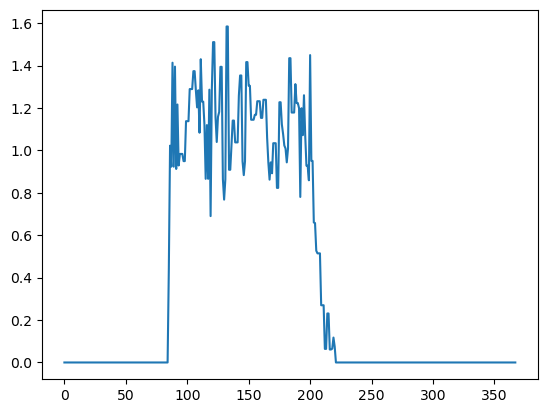

In [8]:
example = labels[(labels['SlowStart']==False) & (labels['SlowEnd']==False)].iloc[0]

pressure_measurements = datadf[(datadf['MachineId'] == example['MachineId']) & (datadf['MeasurementId'] == example['MeasurementId'])]['Pressure']
x = range(0,len(pressure_measurements))
print("Number of measurements: ",len(pressure_measurements))
plt.plot(x, pressure_measurements)

<h3>2.2.2 Příklad SlowStart a SlowEnd</h3>

Number of measurements:  504


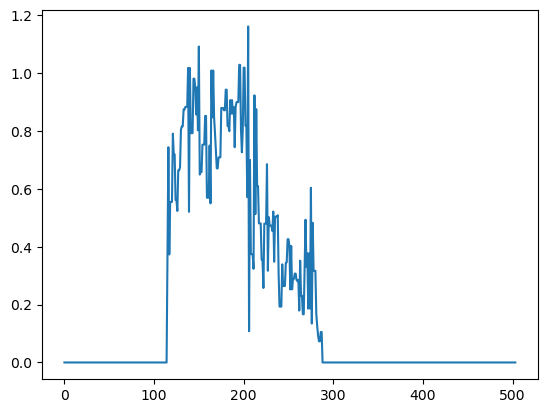

In [9]:
example = labels[(labels['SlowStart']==True) & (labels['SlowEnd']==True)].iloc[0]

pressure_measurements = datadf[(datadf['MachineId'] == example['MachineId']) & (datadf['MeasurementId'] == example['MeasurementId'])]['Pressure']
x = range(0,len(pressure_measurements))
print("Number of measurements: ",len(pressure_measurements))
plt.plot(x, pressure_measurements)

<b>Závěr: SlowStart a SlowEnd labels jsou zavádějící (?).</b></br>
Viz grafy - případy, kdy jsou obě hodnoty True i False vypadá průběh stejně. (otestováno na vícero příkladech)

<h3>2.2.3 Příklad Pump Failure</h3>

Number of measurements:  704


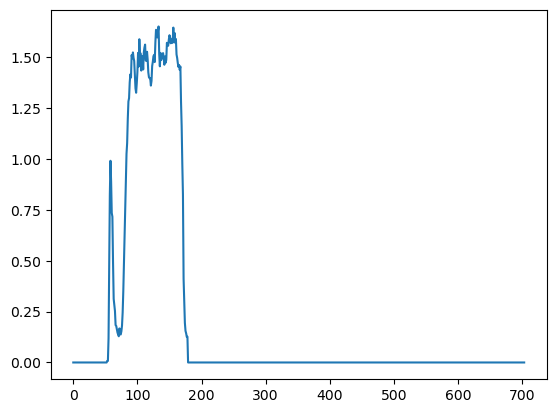

In [10]:
example = labels[(labels['PumpFailed']==True)].iloc[255]

pressure_measurements = datadf[(datadf['MachineId'] == example['MachineId']) & (datadf['MeasurementId'] == example['MeasurementId'])]['Pressure']
x = range(0,len(pressure_measurements))
print("Number of measurements: ",len(pressure_measurements))
plt.plot(x, pressure_measurements)

<h3>2.2.4 Příklad Pump Non-failure</h3>

Number of measurements:  366


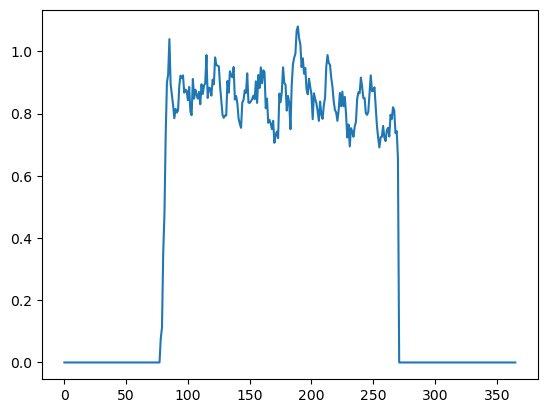

In [11]:
example = labels[(labels['PumpFailed']==False)].iloc[15]

pressure_measurements = datadf[(datadf['MachineId'] == example['MachineId']) & (datadf['MeasurementId'] == example['MeasurementId'])]['Pressure']
x = range(0,len(pressure_measurements))
print("Number of measurements: ",len(pressure_measurements))
plt.plot(x, pressure_measurements)

<h3>2.2.5 Ukázka měření:</h3>
<ul>
    <li>Vlevo: celé měření</li>
    <li>Uprostřed: měření bez počátečních a závěrečných nul, tedy čistě během běhu pumpy</li>
    <li>Vpravo: pouze první polovina měření, tedy úsek, kde nastává Pump Failure (pokud nastane)</li>
</ul>

Text(0.5, 0, 'Measurements: 58')

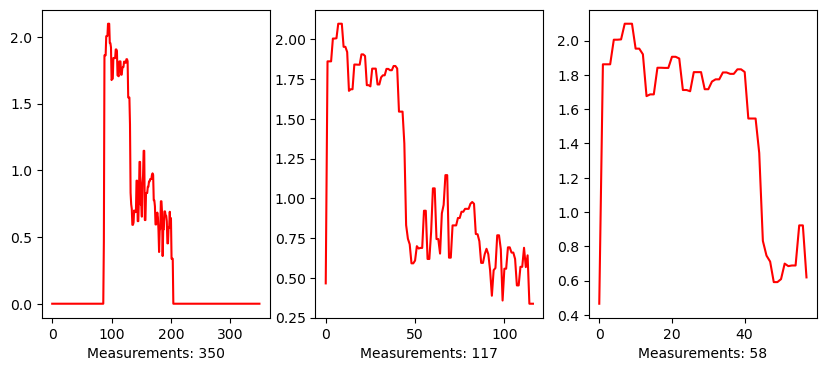

In [12]:
example = labels[(labels['PumpFailed']==False)].iloc[250]
pressure_measurements = datadf[(datadf['MachineId'] == example['MachineId']) & (datadf['MeasurementId'] == example['MeasurementId'])]['Pressure']

#Original
originalY = pressure_measurements
originalX = range(len(pressure_measurements))

#No zeroes
nozeroesY = pressure_measurements[pressure_measurements != 0]
nozeroesX = range(len(nozeroesY))

#No zeroes + first half only
midpoint = int(len(nozeroesY)/2)
firsthalfY = nozeroesY[0:midpoint]
firsthalfX = range(len(firsthalfY))

fig, axs = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 2 columns

axs[0].plot(originalX, originalY, 'r')  # 'r' for red line
axs[0].set_xlabel(f'Measurements: {len(pressure_measurements)}', )

axs[1].plot(nozeroesX, nozeroesY, 'r')  # 'r' for red line
axs[1].set_xlabel(f'Measurements: {len(nozeroesY)}', )

axs[2].plot(firsthalfX, firsthalfY, 'r')  # 'r' for red line
axs[2].set_xlabel(f'Measurements: {len(firsthalfY)}', )

Text(0.5, 0, 'Measurements: 79')

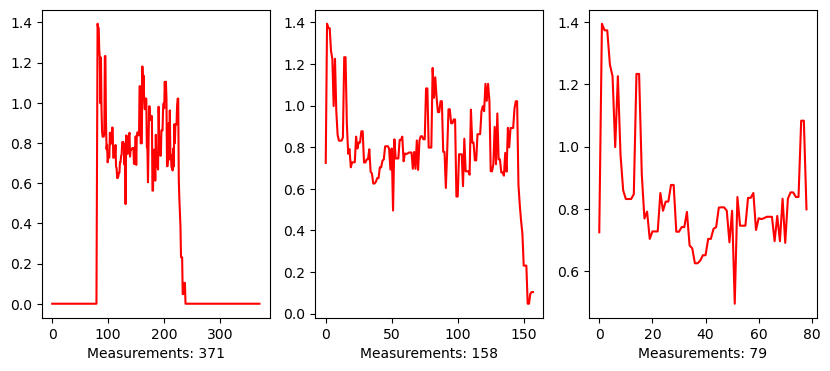

In [13]:
# Pro ověření později - konkrétní kombinace MachineId a MeasurementId

pressure_measurements = datadf[(datadf['MachineId'] == '0_0_0') & (datadf['MeasurementId'] == 1125)]['Pressure']

#Original
originalY = pressure_measurements
originalX = range(len(pressure_measurements))

#No zeroes
nozeroesY = pressure_measurements[pressure_measurements != 0]
nozeroesX = range(len(nozeroesY))

#No zeroes + first half only
midpoint = int(len(nozeroesY)/2)
firsthalfY = nozeroesY[0:midpoint]
firsthalfX = range(len(firsthalfY))

fig, axs = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 2 columns

axs[0].plot(originalX, originalY, 'r')  # 'r' for red line
axs[0].set_xlabel(f'Measurements: {len(pressure_measurements)}', )

axs[1].plot(nozeroesX, nozeroesY, 'r')  # 'r' for red line
axs[1].set_xlabel(f'Measurements: {len(nozeroesY)}', )

axs[2].plot(firsthalfX, firsthalfY, 'r')  # 'r' for red line
axs[2].set_xlabel(f'Measurements: {len(firsthalfY)}', )

Původně jsem chtěl prozkoumat měření více do hloubky skrze směrodatnou odchylku, hledání lokálního/globálního minima, jež signalizuje Pressure Drop a podobné metody. Kvůli časovému omezení jsem se rozhodl tímto směrem nepokračovat.

mean = np.mean(firsthalfY)
std_dev = np.std(firsthalfY)

print(mean, std_dev)

<h1>3. Data Pre-processing</h1>

<h2>1. Labels</h2>

Provedl jsem následující kroky:
<ul>
    <li>Sjednotil jsem ID -> MachineId + MeasurementId</li>
    <li>Zredukoval jsem dataset pouze na Id a PumpFailed. Hodnoty SlowStart a SlowEnd jsem v Data Exploration vyhodnotil jako irelevantní.</li>
    <li>Odstranil jsem záznamy s NaN hodnotami</li>
    <li>Nahradil jsem labels numerickými hodnotami</li>
    <li>Vyrovnal jsem počty záznamu na třídu z důvodu nevyrovnaného datasetu ve prospěch Non-failure záznamů</li>
</ul>

In [14]:
labels['Id'] = labels['MachineId'] + '_' + labels['MeasurementId'].astype(str)
print(len(labels['Id']))
print(len(labels['Id'].unique()))

27385
27385


In [15]:
labels = labels[['Id', 'PumpFailed']]
labels = labels.dropna()
labels['PumpFailed'].replace({True: 1, False: 0}, inplace=True)

In [16]:
print(len(labels[labels['PumpFailed']==1]))
print(len(labels[labels['PumpFailed']==0]))

2942
23958


In [17]:
#Vyrovnání počtu záznamů k jednotlivým třídám v datasetu

labels_majority = labels[labels['PumpFailed']== 0]
labels_minority = labels[labels['PumpFailed']== 1]

labels_majority_downsample = resample(labels_majority,
                                     replace=False,
                                     n_samples=len(labels_minority),
                                     )

labels_balanced = pd.concat([labels_majority_downsample, labels_minority])

labels_balanced.sort_index()

,Id,PumpFailed
3,0_0_3_0,1
5,0_1_1_1,1
18,2_2_2_3,1
22,1_2_2_4,1
26,3_0_2_5,0
...,...,...
27352,0_2_1_8824,0
27356,10_0_0_8826,0
27364,10_2_0_8829,0
27367,10_2_3_8829,0


<h2>2. Data</h2>

Provedl jsem následující kroky:
<ul>
    <li>Sjednotil jsem ID -> MachineId + MeasurementId</li>
    <li>Zredukoval jsem dataset pouze na ID a Pressure</li>
    <li>Zredukoval jsem dataset pouze na hodnoty dostupné v tabulce Labels</li>
    <li>Zploštil jsem dataset - tzn. z více měření pro konkrétní Machine jsem udělal jediný datový vstup ve formě listu</li>
    <li>Odstranil jsem nuly na začátku a konci listu v rámci měření</li>
    <li>Každé měření jsem zredukoval pouze na jeho první polovinu, ve které se, dle zadání, běžně stává Pump Failure</li>
    <li>Sjednotil jsem délky měření pro vstup do ML modelu. Zvolil jsem metodu interpolace namísto paddingu nebo oříznutí. Argumentace pro tento krok v dané sekci.</li>
</ul>

In [18]:
#Odstranění nul z měření
def remove_value_from_list(the_list, value):
    return [x for x in the_list if x != value]

#Uříznutí druhé poloviny měření
def truncate_list(the_list):
    midpoint = int(len(the_list)/2)
    return the_list[:midpoint]

#Interpolace měření na požadovanou velikost
def resample_list(input_list, target_length):
    # Create an array of the original indices
    original_indices = np.linspace(0, 1, len(input_list))
    
    # Create an array of the target indices
    target_indices = np.linspace(0, 1, target_length)
    
    # Interpolate using 1D linear interpolation
    interp_func = interpolate.interp1d(original_indices, input_list, kind='linear')
    
    # Use the interpolation function to resample the list
    resampled_list = interp_func(target_indices)
    
    return resampled_list

In [19]:
datadf['Id'] = datadf['MachineId'] + '_' + datadf['MeasurementId'].astype(str)
datadf = datadf[['Id', 'Pressure']]
mask = datadf['Id'].isin(labels_balanced['Id'])
datadf_filtered = datadf[mask]
datadf_filtered = datadf_filtered.sort_index()

In [20]:
datadf_filtered_flat = datadf_filtered.groupby('Id')['Pressure'].agg(list).reset_index()
datadf_filtered_flat = datadf_filtered_flat.sort_values(by='Id', ascending=True)

In [21]:
#Odstranění nul (start a konec)

datadf_filtered_flat['Pressure'] = datadf_filtered_flat['Pressure'].apply(lambda x: remove_value_from_list(x, 0))

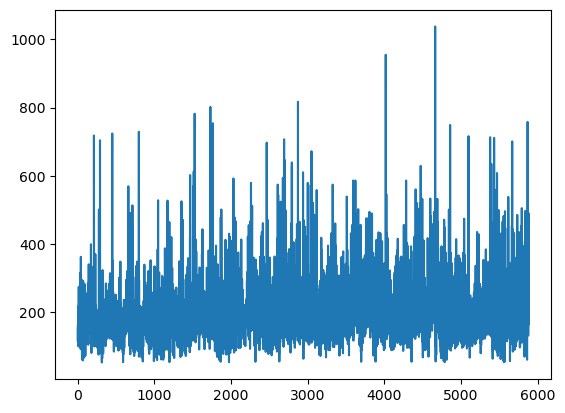

In [22]:
#Zjištění počtu měření na konkrétní Machine

datadf_filtered_flat['PressureLen'] = datadf_filtered_flat['Pressure'].apply(len)

#Odstranění machines, které mají příliš málo měření

datadf_filtered_flat = datadf_filtered_flat[datadf_filtered_flat['PressureLen'] > 50] 

plt.plot(datadf_filtered_flat['PressureLen'])

In [23]:
#Odstranění druhé poloviny měření

datadf_filtered_flat['Pressure'] = datadf_filtered_flat['Pressure'].apply(truncate_list)

In [24]:
datadf_filtered_flat

,Id,Pressure,PressureLen
0,0_0_0_1125,"[0.7249310027598896, 1.3937442502299908, 1.372...",158
1,0_0_0_1142,"[0.1800411522633745, 1.0432098765432098, 1.484...",114
2,0_0_0_1407,"[0.9823702252693438, 1.216454456415279, 0.9823...",130
3,0_0_0_1505,"[0.12919633774160733, 0.6093591047812817, 0.85...",154
4,0_0_0_1592,"[0.010482180293501049, 0.039832285115303984, 0...",139
...,...,...,...
5879,9_5_3_4223,"[0.060860440713536204, 0.24449108079748164, 0....",170
5880,9_5_3_4229,"[0.08363970588235294, 0.2913602941176471, 0.41...",334
5881,9_5_3_4232,"[0.07516650808753568, 0.368220742150333, 0.368...",163
5882,9_5_3_4238,"[0.42446808510638295, 0.6829787234042554, 0.72...",490


In [25]:
len(datadf_filtered_flat)

5865

<b>Příprava na Machine Learning: nutné mít vstupy (měření) ve stejné velikosti.</b>

V úvahu přichází 2 hlavní metody, jak tohoto dosáhnout - padding a truncating.
- Padding -> přidání nul na začátek či konec měření by mohlo negativně ovlivnit výkon modelu.
- Truncating -> oříznutí měření na konkrétní délku (minimální délka měření v rámci datasetu) by mohlo mít za následek, že ořízneme část měření, ve které došlo k Pressure dropu (příliš brzy).

Proto jsem se rozhodl pro jinou metodu, tedy interpolaci. Skrze interpolaci natáhneme (v případě menšího, než požadovaného) nebo "zcvrkneme" (v případě většího) celé měření.

In [26]:
#Interpolace

datadf_filtered_flat['PressureSame'] = datadf_filtered_flat['Pressure'].apply(lambda x: resample_list(x, 200))

#Ověření, že interpolace proběhla správně

datadf_filtered_flat['PressureSameLen'] = datadf_filtered_flat['PressureSame'].apply(len)

datadf_filtered_flat

,Id,Pressure,PressureLen,PressureSame,PressureSameLen
0,0_0_0_1125,"[0.7249310027598896, 1.3937442502299908, 1.372...",158,"[0.7249310027598896, 0.987078908803447, 1.2492...",200
1,0_0_0_1142,"[0.1800411522633745, 1.0432098765432098, 1.484...",114,"[0.1800411522633745, 0.4229429038195091, 0.665...",200
2,0_0_0_1407,"[0.9823702252693438, 1.216454456415279, 0.9823...",130,"[0.9823702252693438, 1.0576535960901472, 1.132...",200
3,0_0_0_1505,"[0.12919633774160733, 0.6093591047812817, 0.85...",154,"[0.12919633774160733, 0.31257508294268904, 0.4...",200
4,0_0_0_1592,"[0.010482180293501049, 0.039832285115303984, 0...",139,"[0.010482180293501049, 0.02051136184064979, 0....",200
...,...,...,...,...,...
5879,9_5_3_4223,"[0.060860440713536204, 0.24449108079748164, 0....",170,"[0.060860440713536204, 0.13837287170374432, 0....",200
5880,9_5_3_4229,"[0.08363970588235294, 0.2913602941176471, 0.41...",334,"[0.08363970588235294, 0.256914166420337, 0.374...",200
5881,9_5_3_4232,"[0.07516650808753568, 0.368220742150333, 0.368...",163,"[0.07516650808753568, 0.19297725544946426, 0.3...",200
5882,9_5_3_4238,"[0.42446808510638295, 0.6829787234042554, 0.72...",490,"[0.42446808510638295, 0.6928418689190634, 0.73...",200


In [27]:
datadf_filtered_flat = datadf_filtered_flat[['Id', 'PressureSame']]

In [44]:
#Sjednocení dat a tříd

joined = pd.merge(datadf_filtered_flat, labels_balanced, on='Id', how='inner')

In [29]:
joined

,Id,PressureSame,PumpFailed
0,0_0_0_1125,"[0.7249310027598896, 0.987078908803447, 1.2492...",1
1,0_0_0_1142,"[0.1800411522633745, 0.4229429038195091, 0.665...",1
2,0_0_0_1407,"[0.9823702252693438, 1.0576535960901472, 1.132...",0
3,0_0_0_1505,"[0.12919633774160733, 0.31257508294268904, 0.4...",0
4,0_0_0_1592,"[0.010482180293501049, 0.02051136184064979, 0....",1
...,...,...,...
5860,9_5_3_4223,"[0.060860440713536204, 0.13837287170374432, 0....",0
5861,9_5_3_4229,"[0.08363970588235294, 0.256914166420337, 0.374...",0
5862,9_5_3_4232,"[0.07516650808753568, 0.19297725544946426, 0.3...",0
5863,9_5_3_4238,"[0.42446808510638295, 0.6928418689190634, 0.73...",0


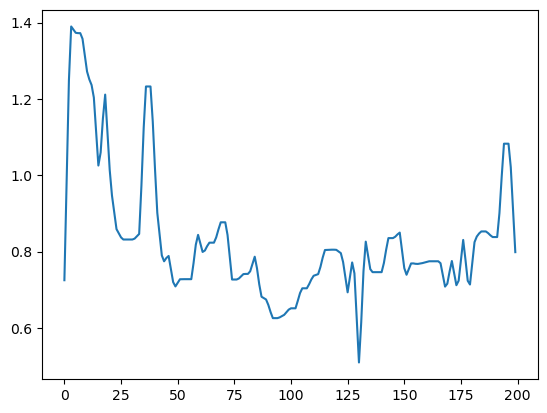

In [30]:
# Finální ověření na konkrétní kombinaci MachineId a MeasurementId, že pre-processing dat proběhl v pořádku.

plt.plot(np.array(joined[joined['Id'] == '0_0_0_1125']['PressureSame'])[0])

Nyní máme dataset připravený jako vstup pro klasifikační model.

<h1>4. Model</h1>

Vyzkoušel jsem celkově 4 modely

- LogisticRegression
- MLPClassifier
- LSTM
- Conv1D

<b>LSTM</b> model měl ze všech modelů nejhorší výkon, který nebyl o nic lepší, než hození mincí. Pravděpodobně je to zapříčeněno tím, že LSTM je spíše vhodné pro hledání dlouhodobých trendů a komplexnějších vztahů, nikoli hledání lokálního minima, což je náš případ.

<b>Logistic Regression</b> mělo Accuracy zhruba 75%, ale rozhodl jsem se prozkoumat ještě jiné modely.

<b>MLPClassifier</b> a <b>Conv1D</b> se ukázaly ze všech 4 modelů jako nejpřesnější díky své schopnosti hledat lokální extrémy (spikes, drops - v našem případě strmý pád v tlaku). Oba mají téměř identickou Accuracy, ale liší se hlavně v Precision a Sensitivity. MLPClassifier má o něco vyšší Precision (94% vs 85%), zatímco Conv1D má o trochu vyšší Sensitivity (79% vs 81%). <i>Tyto závěry jsem sepisoval po prvním zavedení modelů. Skrze přetrénování a ladění modelů se tato čísla mohla změnit, logika ale zůstává.</i>

K metrikám a mé interpretaci v rámci kontextu tohoto cvičení:
- <b>Precision (TP/TP+FP):</b> Značí přesnost ve správném uhodnutí Failure oproti všem uhodnutím Failure. Precision je důležitá v případech, kdy špatně predikované True hodnoty mají velký impact. Například, pokud po každém predikování Failure automaticky nastává reklamace pumpy, pak se nižší Precision může prodražit.
- <b>Sensitivity (TP/TP+FN):</b> Značí míru uhodnutí v rámci všech Failure případů. Důležité, když nám jde o vychytání co nejvíce Failure případů. Pokud například chyba pumpy má velké důsledky pro chod většího systému, je důležité abychom správně predikovali všechny případy pro co nejrychlejší opravu.
- <b>Specificity (TN/TN+FP):</b> Vysoká Specificity je důležitá v případech, kdy neschopnost predikovat False hodnoty (v našem případě Non-failure) může mít velké důsledky. V našem případě tato metrika není tak důležitá, jako například ve zdravotnictví, kdy negativní případy predikované jako pozitivní mohou vést k nepotřebné (tudíž škodlivé) léčbě.

<br>

<b>Závěr a výběr modelu na základě Precision a Sensitivity</b><br>
Celkové vyhodnocení modelu tedy záleží na tom, o jaké pumpy se jedná a jaké jsou důsledky jejich pochybení - zdali to jsou spíše uživatelská zařízení, kde nám spíše vadí nižší Precision, která se může například skrze reklamace prodražit, nebo o průmyslové pumpy, jejichž selhání může způsobit zdržení či kolaps většího systému. S ohledem na tento kontext se poté nabízí volba mezi MLPClassifier, který má spíše lepší Precision, nebo Conv1D, které má lepší Sensitivity. <i>Tyto závěry jsem sepisoval po prvním zavedení modelů. Skrze přetrénování a ladění modelů se tato čísla mohla změnit, logika ale zůstává.</i>

<i>Kvůli časovému omezení cvičení jsem bohužel neměl čas zkoumat a ladit modely více do podrobna, nebo zkusit více modelů.</i>

In [31]:
X = np.stack(joined['PressureSame'].values)
y = joined['PumpFailed'].values

In [32]:
#Normalizace dat

min_max_scaler = MinMaxScaler()
X_min_max_scaled = min_max_scaler.fit_transform(X)

In [33]:
#Rozdělení dat i labels na trénovací a testovací datasety (80/20)

X_train, X_test, y_train, y_test = train_test_split(X_min_max_scaled, y, test_size=0.20, random_state=42)

<h2>LogisticRegression</h2>

<h2>MLPClassifier</h2>

In [34]:
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=3000)

model.fit(X_train, y_train)

MLPClassifier(max_iter=3000)

In [35]:
predictionsmlpc = model.predict(X_test)

In [36]:
accuracy = accuracy_score(y_test, predictionsmlpc)
report = classification_report(y_test, predictionsmlpc)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8618925831202046
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       608
           1       0.85      0.87      0.86       565

    accuracy                           0.86      1173
   macro avg       0.86      0.86      0.86      1173
weighted avg       0.86      0.86      0.86      1173



In [37]:
cmmlpc = confusion_matrix(y_test, predictionsmlpc)

print(f"Precision: {round(cmmlpc[1,1]/(cmmlpc[1,1]+cmmlpc[0,1]), 3)}")
print(f"Sensitivity: {round(cmmlpc[1,1]/(cmmlpc[1,1]+cmmlpc[1,0]), 3)}")
print("")
print(f"Ze všech případů, kdy model hlásil Failure, v {(round(cmmlpc[1,1]/(cmmlpc[1,1]+cmmlpc[0,1]),2))*100}% případů predikoval správně.")
print(f"Ze všech případů, kdy nastalo Failure, model jich {(round(cmmlpc[1,1]/(cmmlpc[1,1]+cmmlpc[1,0]),2))*100}% predikoval.")

Precision: 0.85
Sensitivity: 0.865

Ze všech případů, kdy model hlásil Failure, v 85.0% případů predikoval správně.
Ze všech případů, kdy nastalo Failure, model jich 87.0% predikoval.


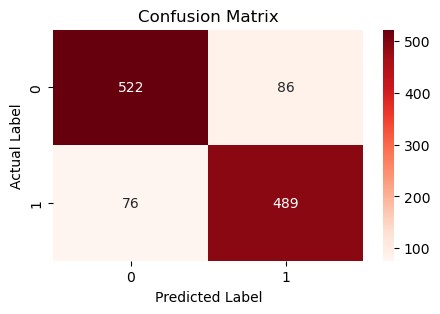

In [38]:
plt.figure(figsize=(5,3))
sns.heatmap(cmmlpc, annot=True, fmt="d", cmap="Reds")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

<h2>LSTM</h2>

<h2>Conv1D</h2>

In [39]:
kernel_size = 50 # Určuje velikost "okna", ve kterém model hledá vzorce. Původní hodnota byla 3, nicméně Pressure Drop značící Failure je otázka více timestampů v rámci měření, tudíž jsem rozšířil okno na 50, což vedlo k zlepšení výkonu modelu.

model = Sequential([
    Conv1D(filters=64, kernel_size=kernel_size, activation='relu', input_shape=(200, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision()])

model.summary()

history = model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 151, 64)           3264      
                                                                 
 max_pooling1d (MaxPooling1  (None, 75, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense (Dense)               (None, 50)                240050    
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 243365 (950.64 KB)
Trainable params: 243365 (950.64 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [40]:
predictions = model.predict(X_test)

binary_predictions = np.where(predictions > 0.5, 1, 0)

accuracy = accuracy_score(y_test, binary_predictions)
report = classification_report(y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

37/37 [==============================] - 0s 792us/step
Accuracy: 0.855072463768116
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       608
           1       0.85      0.85      0.85       565

    accuracy                           0.86      1173
   macro avg       0.85      0.85      0.85      1173
weighted avg       0.86      0.86      0.86      1173



In [42]:
cm = confusion_matrix(y_test, binary_predictions)

print(f"Precision: {round(cm[1,1]/(cm[1,1]+cm[0,1]), 3)}")
print(f"Sensitivity: {round(cm[1,1]/(cm[1,1]+cm[1,0]), 3)}")
print("")
print(f"Ze všech případů, kdy model hlásil Failure, v {(round(cm[1,1]/(cm[1,1]+cm[0,1]),2))*100}% případů predikoval správně.")
print(f"Ze všech případů, kdy nastalo Failure, model jich {(round(cm[1,1]/(cm[1,1]+cm[1,0]),2))*100}% predikoval.")

Precision: 0.848
Sensitivity: 0.851

Ze všech případů, kdy model hlásil Failure, v 85.0% případů predikoval správně.
Ze všech případů, kdy nastalo Failure, model jich 85.0% predikoval.


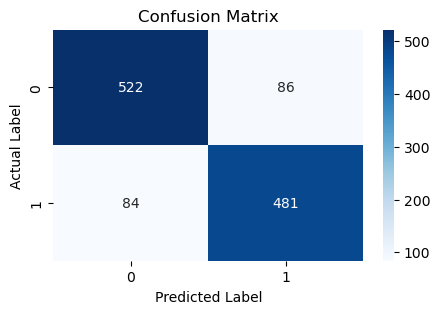

In [43]:
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt="d",  cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

y_scores = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr,  lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],  lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()